### 读取提取模板所保存的光谱数据

In [1]:
import pandas as pd 
import numpy as np
df1 = pd.read_csv(rf'E:\code\Spectrum_analyse\SpectralAnalysis\tobacoo_0830_上午.csv', index_col= 0 ,  header=0)
df2 = pd.read_csv(rf'E:\code\Spectrum_analyse\SpectralAnalysis\tobacoo_0830_下午.csv', index_col= 0 ,  header=0)
# df3 = pd.read_csv(rf'E:\code\Spectrum_analyse\SpectralAnalysis\tobacoo_8030下午_C4F.csv', index_col= 0 ,  header=0 )
# df4 = pd.read_csv(rf'E:\code\Spectrum_analyse\SpectralAnalysis\tobacoo_8030下午_C3F_2.csv', index_col= 0 ,  header=0 )

In [2]:
# values_concatenated = np.concatenate((df1.values, df2.values, df3.values , df4.values), axis=0)
values_concatenated = np.concatenate((df1.values, df2.values), axis=0)
df = pd.DataFrame(values_concatenated)
df.columns = df1.columns
df.index = list(df1.index) + list(df2.index)
# df.index = list(df1.index) + list(df2.index) + list(df3.index)+ list(df4.index)

In [3]:
import pandas as pd 
import numpy as np
labels = df.index.values
labels =  [i.split('-')[1] for i in labels]
wave = [float(i) for i in df.columns[0:19]]
spectrum = df.values

### 绘图查看数据情况

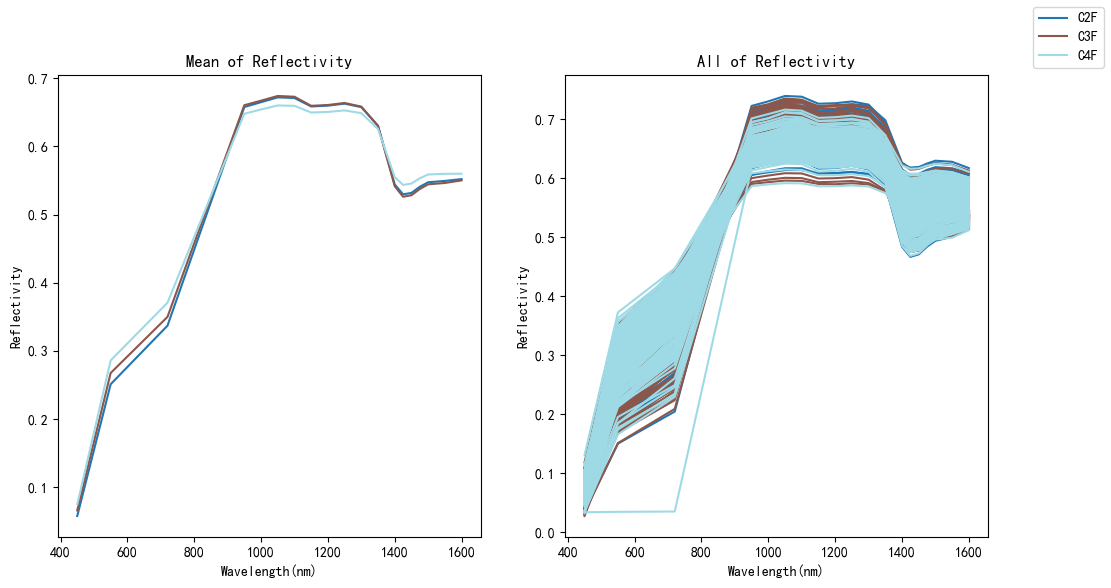

In [4]:
import importlib
import SpectrumAnalyse  # 导入模块
importlib.reload(SpectrumAnalyse)
# 导入需要的函数
from SpectrumAnalyse import plot_duplicate_data_both, split_data
import matplotlib.pyplot as plt

category,  split_datas = split_data(labels , spectrum[:,0:19])
plot_duplicate_data_both(category,  split_datas , wave  , save=False) 


### 预处理方法列表

In [ ]:
# from sklearn.preprocessing import StandardScaler
# def none(data):
#     scaler = StandardScaler()
#     data = scaler.fit_transform(data.copy())
#     return data


In [6]:


import numpy as np
import pandas as pd
from tqdm import tqdm  # 导入 tqdm 库
importlib.reload(SpectrumAnalyse)
from SpectrumAnalyse import msc, snv, CT, MA, SG, pca ,none
from SpectrumAnalyse import SPA_select, k_fold_cross_validation, leave_one_out_cross_validation, mean_squared_error, pearson_correlation, plot_duplicate_data, plot_duplicate_data_both, plot_selected_features, split_data

preprocessing_functions = {
    '仅做标准化': none,
    'MSC': msc,
    'SNV': snv,
    'CT': CT,
    # 'MA': MA,
    # 'SG': SG,
    # 'PCA': pca,

}


### 网格调参结合各种预处理方法选优

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
# 创建 StandardScaler 对象
scaler = StandardScaler()



random_seed = 53
random.seed(random_seed)
np.random.seed(random_seed)

# 定义SVM模型
model = SVC()

# 定义参数网格
param_grid = {
    'C': [1,  100 ,500],  # 惩罚参数
    'kernel': ['linear'],  # 核函数类型
    'gamma': ['scale']  # 核函数的gamma值
}

from sklearn.model_selection import StratifiedKFold

# 使用 StratifiedKFold 并传递 random_state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
# 创建GridSearchCV对象，使用5折交叉验证（可以调整交叉验证的折数）
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=1, verbose=1, scoring='accuracy' )

test_results = []

# 使用 tqdm 进行进度条显示
for name, func in tqdm(preprocessing_functions.items(), desc="Processing Functions"):

    results = []
    results.append(name)

    # 预处理流水线，可自行添加
    processed_spectrum = func(spectrum.copy())
    processed_spectrum = scaler.fit_transform(processed_spectrum)

    # 使用K-折交叉验证网格调参
    grid_search.fit(processed_spectrum, labels)

    results.append(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    best_score = k_fold_cross_validation(processed_spectrum, np.array(labels), best_model, n_splits=5 , random_state = random_seed , show= False)

    results.append(np.array(best_score).round(2))
    test_results.append(results)

pd.DataFrame(test_results)

Processing Functions:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Processing Functions:  25%|██▌       | 1/4 [00:54<02:42, 54.10s/it]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Processing Functions:  50%|█████     | 2/4 [01:24<01:20, 40.33s/it]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Processing Functions:  75%|███████▌  | 3/4 [01:37<00:27, 27.59s/it]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Processing Functions: 100%|██████████| 4/4 [02:30<00:00, 37.64s/it]


,0,1,2
0,仅做标准化,"{'C': 500, 'gamma': 'scale', 'kernel': 'linear'}",0.86
1,MSC,"{'C': 500, 'gamma': 'scale', 'kernel': 'linear'}",0.70
2,SNV,"{'C': 500, 'gamma': 'scale', 'kernel': 'linear'}",0.69
3,CT,"{'C': 500, 'gamma': 'scale', 'kernel': 'linear'}",0.86


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
random_seed = 53

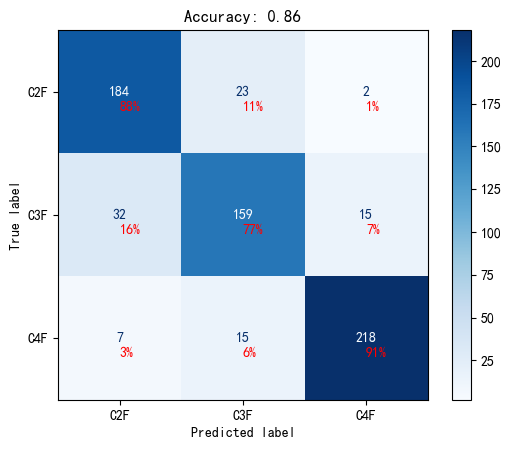

0.8564885496183207

In [11]:
best_model =SVC(C=1000 , kernel='linear' , gamma='scale')
spectrum_scaled = scaler.fit_transform(spectrum.copy())
k_fold_cross_validation(snv(spectrum_scaled), np.array(labels), best_model, n_splits=5 , random_state = random_seed )


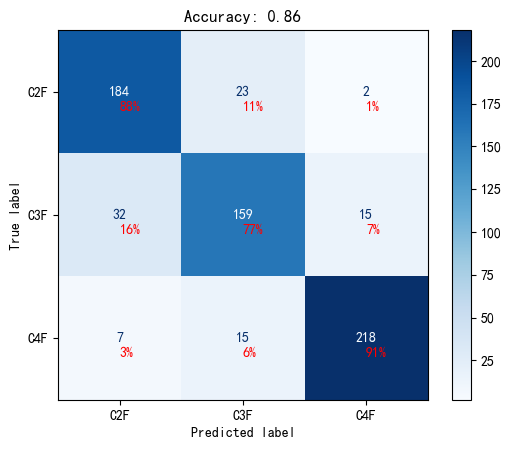

0.8564885496183207

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
k_fold_cross_validation2(snv(spectrum_scaled), np.array(labels), best_model, n_splits=5 , random_state = random_seed )

In [14]:
def k_fold_cross_validation2(X, y, model, n_splits=5 , random_state=42 , show=True):
    """
    使用五折交叉验证训练模型，并绘制混淆矩阵。
    
    参数:
    X : numpy array
        特征矩阵 (n_samples, n_features)
    y : numpy array or list
        标签对应的特征矩阵
    model : sklearn model
        要训练的机器学习模型
    n_splits : int
        交叉验证的折数，默认为5
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    Y_pred = []
    Y_test = []

    # 进行五折交叉验证
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = SVC(C=1000 , kernel='linear' , gamma='scale')

        # 训练模型
        model.fit(X_train, y_train)

        # 预测
        y_pred = model.predict(X_test)

        # 汇总结果
        Y_pred.extend(y_pred)
        Y_test.extend(y_test)

    accuracy = accuracy_score(Y_test, Y_pred)

    if show:
        # 计算混淆矩阵
        cm = confusion_matrix(Y_test, Y_pred)

        # 获取唯一的标签
        unique_labels = np.unique(y)

        # 绘制混淆矩阵
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
        disp.plot(cmap=plt.cm.Blues)

        # 计算它们的迭代位置
        iters = np.reshape([[[i, j] for j in range(cm.shape[1])] for i in range(cm.shape[0])], (cm.size, 2))

        # 计算每个单元格的百分比
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        # 显示数字和百分比
        for i, j in iters:
            if (i == j):
                plt.text(j, i + 0.12, f'{cm_percentage[i, j]:.0f}%', va='center', ha='left', fontsize=10, color='red')  # 显示百分比
            else:
                plt.text(j, i + 0.12, f'{cm_percentage[i, j]:.0f}%', va='center', ha='left', fontsize=10, color='red')  # 显示百分比

        plt.title(f"Accuracy: {accuracy:.2f}")
        plt.show()

    return accuracy

### 保存模型并且使用新的模型进行预测

In [30]:
import pandas as pd 
import numpy as np
from sklearn.svm import SVC
import  joblib
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(rf'E:\code\Spectrum_analyse\SpectralAnalysis\tobacoo_0830_上午.csv' , index_col = 0 , header=0)
labels = df.index.values
labels =  [i.split('-')[1] for i in labels]
spectrum = df.values

scaler = StandardScaler()
spectrum_scaled = scaler.fit_transform(spectrum)
joblib.dump(scaler, 'standard_scaler.pkl')


### 训练并且保存模型
model = SVC(C=1 , kernel='linear' , gamma='scale')
model.fit(spectrum_scaled, labels)
import  joblib
joblib.dump(model, 'dayanye.pkl')
print('模型保存成功')


模型保存成功


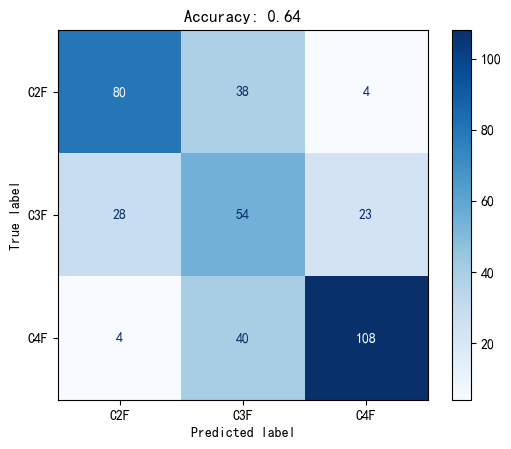

In [31]:
### 加载模型
model = joblib.load('dayanye.pkl')


import joblib

# 加载之前保存的 StandardScaler 模型
scaler = joblib.load('standard_scaler.pkl')


import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from SpectrumAnalyse import snv

df = pd.read_csv(rf'E:\code\Spectrum_analyse\SpectralAnalysis\tobacoo_0830_下午.csv' , index_col = 0)
labels2 = df.index.values
labels2 =  [i.split('-')[1] for i in labels2]
spectrum2 = df.values
spectrum2 = spectrum2
new_spectrum_scaled = scaler.transform(spectrum2)


predit = model.predict(new_spectrum_scaled)
cm = confusion_matrix(labels2, predit)

# 获取唯一的标签
unique_labels = np.unique(labels2)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
accuracy = accuracy_score(labels2, predit)
plt.title(f"Accuracy: {accuracy:.2f}")
plt.show()
